In [1]:
import matplotlib.pyplot as plt
import numpy as np
from graspy.simulations import sbm
from numpy.random import normal, poisson
from scipy.stats import norm
import random
import itertools
from math import exp as ex
from math import log
import matplotlib.pyplot as plt
from load_dataset import load_COBRE, load_UMich
from graspy.plot import heatmap
%matplotlib inline

In [2]:
def fit_cls(A,e,y,iter,a,rho,gamma,count):
    sampleTest,N,_ = A.shape
    dim,_ = e.shape
    B = np.ones((dim,N,N), dtype=float)/(dim*N*N)
    b = 0

    for itr in range(1,iter):
        gradB = np.zeros((dim,N,N), dtype=float)
        sym = np.zeros((dim,N,N), dtype=float)
        gradb = 0
        for k in range(0,sampleTest):
            tmp = b
            tmpGradB = np.zeros((dim,N,N), dtype=float) 
            for i in range(0,dim):
                if y[k] == i:
                    for j in range(0,dim):
                        tmp -= e[i,j]*np.sum(B[j,:,:]*A[k,:,:])/count[i]
                        tmpGradB[j,:,:] -= e[i,j]*A[k,:,:]/count[i]
                else:
                    for j in range(0,dim):
                        tmp += e[i,j]*np.sum(B[j,:,:]*A[k,:,:])/count[i]
                        tmpGradB[j,:,:] += e[i,j]*A[k,:,:]/count[i]
        
            phi = ex(tmp)
            phi_ = phi/(1+phi)
            
            gradB += phi_*tmpGradB
            
        for i in range(0,dim):
            sym[i,:,:] = 2*(B[i,:,:]-B[i,:,:].T)

        gradB = gradB/sampleTest + rho*np.sign(B) + 2*gamma*B + sym
        B = B - a*gradB
        
        for k in range(0,sampleTest):
            tmp = b 
            for i in range(0,dim):
                if y[k] == i:
                    for j in range(0,dim):
                        tmp -= e[i,j]*np.sum(B[j,:,:]*A[k,:,:])/count[i]
                else:
                    for j in range(0,dim):
                        tmp += e[i,j]*np.sum(B[j,:,:]*A[k,:,:])/count[i]
            
            phi = ex(tmp)
            
            gradb += phi/(1+phi)
            
        b = b - a*gradb/sampleTest
    return B,b

In [3]:
def crossValidate(A,e,y,iter,stepSize,rho,gamma,fold):
    accuracy = 0
    _,count = np.unique(y, return_counts=True)
    totalSample, N, _ = A.shape
    
    count = count/totalSample
    indx = np.asarray(range(0,totalSample))
    random.shuffle(indx)
    
    testSample = int(totalSample/fold)
    for i in range(0,fold):
        _,count = np.unique(y[indx[0:totalSample-testSample]], return_counts=True)
        count = count/(totalSample-testSample)
        
        indx = np.roll(indx,testSample)
        B,b = fit_cls(A[indx[0:totalSample-testSample],:,:],e,y[indx[0:totalSample-testSample]],iter,stepSize,rho,gamma,count)
        testAccuracy = predictAccuracy(B,b,e,A[indx[totalSample-testSample:totalSample],:,:],y[indx[totalSample-testSample:totalSample]])
        accuracy += testAccuracy

    accuracy = accuracy/fold
    return accuracy

In [4]:
def predictAccuracy(B,b,e,A,y):
    l = len(y)
    dim,_,_ = B.shape
    accuracy = 0
    
    for i in range(0,l):
        lbl = []
        val = 0
        for j in range(0,dim):
            lbl.append(sum(e[j,k]*np.sum(B[k,:,:]*A[i,:,:]) for k in range(0,dim)))
            
        #print(lbl)
        cls = np.argmax(np.asarray(lbl))
        #print(e@R@A[i,:,:]@C,y[i])
        #print('hi')
        #print(cls, y[i])
        if cls == y[i]:
            accuracy += 1

    return accuracy*100/l

In [5]:
def getBase(dim):
    e = np.zeros((dim,dim),dtype=float)
    labelVec = np.asarray(range(1,dim+1),dtype=float)
    e[0,:] = labelVec/(labelVec@labelVec.T)**.5

    for i in range(1,dim):
        tmp = np.roll(labelVec,i)
        tmp = tmp.reshape(1,-1)
        tmp_ = tmp.copy()
        for j in range(0,i):
            eTmp = e[j,:].reshape(1,-1)
            tmp_ -= (tmp@eTmp.T/(eTmp@eTmp.T))*eTmp
            #print(tmp.shape)
        e[i,:] = tmp_/(tmp_@tmp_.T)**.5
    return e


In [ ]:
fold = 10
accuracy = 0

A, y = load_COBRE(ptr=True)
_,count = np.unique(y, return_counts=True)
dim = len(count)
e = getBase(dim)
totalSample, N, _ = A.shape

count = count/totalSample
indx = np.asarray(range(0,totalSample))
random.shuffle(indx)

testSample = int(totalSample/fold)
for i in range(0,fold):
    print("Doing test on %d fold.........\n"%(i+1))
    _,count = np.unique(y[indx[0:totalSample-testSample]], return_counts=True)
    count = count/(totalSample-testSample)
    
    print(count)
    
    #find the optimum parameter
    rhoOpt = 0
    maxAcc = 0
    for rho in np.linspace(1e-5,1e-3,14):
        print('Tesing for rho=%g\n'%rho)
        acc = crossValidate(A[indx[0:totalSample-testSample],:,:],e,y[indx[0:totalSample-testSample]],13000,1e-3,rho,1e-4,4)
        print('Accuracy for rho=%g is %f\n'%(rho,acc))
        if maxAcc < acc:
            maxAcc = acc
            rhoOpt = rho
            
            
    B,b = fit_cls(A[indx[0:totalSample-testSample],:,:],e,y[indx[0:totalSample-testSample]],4000,1e-3,rhoOpt,1e-4,count)
    testAccuracy = predictAccuracy(B,b,e,A[indx[totalSample-testSample:totalSample],:,:],y[indx[totalSample-testSample:totalSample]])
    accuracy += testAccuracy
    print(testAccuracy)
    
    indx = np.roll(indx,testSample)
accuracy = accuracy/fold
print("Total accuracy %f\n"%accuracy)


Doing test on 1 fold.........

[0.58035714 0.41964286]
Tesing for rho=1e-05



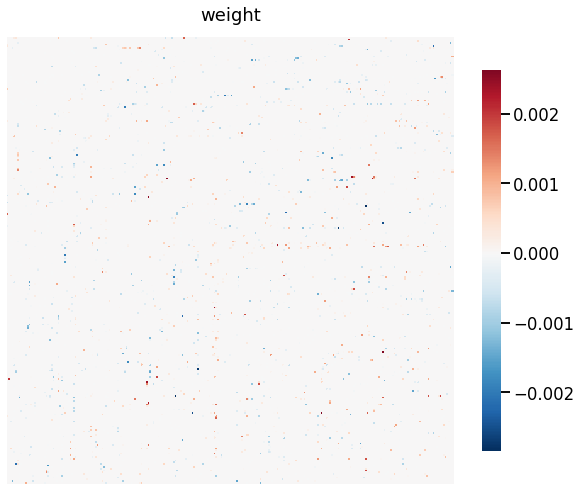

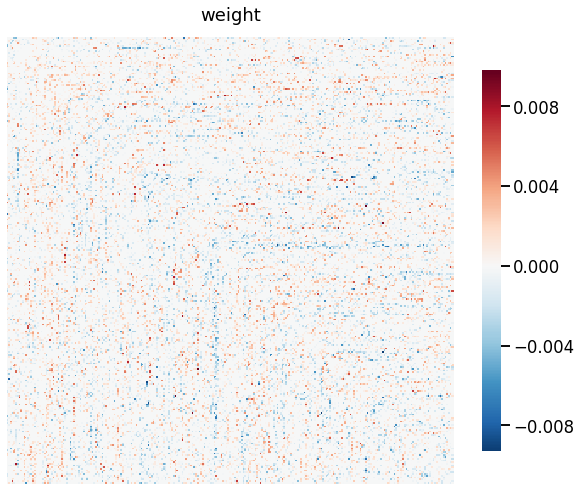

In [92]:
heatmap(B[0,:,:], title ='weight')
heatmap(B[1,:,:], title ='weight')

In [31]:
e = np.asarray([[1,-1],[-1,1]])

In [31]:
b

-1.423412007327299

In [72]:
testAccuracy = predictAccuracy(B,b,e,A[indx[totalSample-testSample:totalSample],:,:],y[indx[totalSample-testSample:totalSample]])
print(testAccuracy)


[-0.06963989136266363, 0.08293448636602474]
1 0
[0.32509028566069015, -0.21820538811894263]
0 0
[1.4446468666827852, -0.9679501229927214]
0 0
[1.0081042530536521, -0.6748993961954264]
0 0
[-0.35519972915125214, 0.21602499653413323]
1 1
[-0.39168905665998843, 0.24847126060350613]
1 1
[1.1849993853610612, -0.749088070170258]
0 0
[1.2571679891268177, -0.839147499496417]
0 0
[-0.2899698684156524, 0.19182352598564267]
1 1
[-0.9475211435343872, 0.5833905500119696]
1 1
[0.8290338444985936, -0.5290109793691263]
0 0
[0.7319247716437818, -0.4696262254149114]
0 0
91.66666666666667


In [84]:
indx = np.roll(indx,testSample)

In [85]:
indx

array([ 24,  41,  43,  50,  78,  74,  55, 115,  12, 108,  15,  56,   8,
       102,  13,  92,   7, 107, 114, 117,  51,  45,  71,  32,   9,  85,
        98,  58,  69,  75,  94, 106, 118,  64,  93,  81,  40,  66,  80,
       116,  21,  89,  46, 111,  83,  60, 122,  49,  42,  68,  23,  20,
       121,  61,  35,  52, 112,  18, 101,  10,  33,   1,  87,  97,  73,
        19,  76,  63,  36, 113, 123,   4,   3,  96,  86, 110,  99, 103,
        29,   6,  70,  57,  48,  54,  90,  34,  30,  65,  26,  62,  91,
        25,  84,  37,  82,  27,  77,  11, 104,  31,  39,  72,  67,  95,
       100,  59,   0, 109,  44, 119,  53,  28,  17,  79,  16,  47, 105,
         5,  38,   2,  22, 120,  14,  88])

In [125]:
print('Accuracy for rho=%g is %f\n'%(rho,acc))

Accuracy for rho=1e-05 is 83.928571

